## Most missing SVs lie in tandem repeats


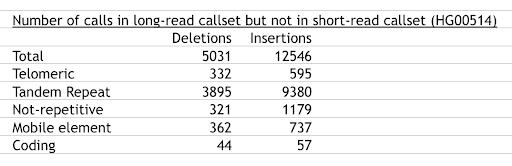

In [1]:
# based upon Supplementary Data 53 of Chaisson et al 2019 and private communication with Mark Chaisson
from IPython.display import Image
Image(filename='most_missing_SVs_lie_in_tandem_repeats.png')

 <blockquote>The increase in sensitivity (threefold) from the [long-read] SV callset relative to the [short-read] SV callset was predominantly derived from improved detection of [tandem-]repeat-associated SV classes, particularly of intermediate-sized SVs (50 bp to 2kb) -- Mark Chaisson</blockquote>

## Decision tree to predict variation at tandem repeats

The number of copies of a repeat unit in a tandem repeat can vary among individuals. The most likely scenario is that a single copy is removed/inserted, but changes involving more than one copy are possible too.

I trained a decision tree to predict whether a tandem repeat harbored a 100-105bp deletion based upon features of the tandem repeat such as period (length of the repeat unit), number of copies (of the repeat unit), degree of similarity among the repeat units, and length of the tandem repeat (copies * period). The labels ("contains event" and "does not contain event") were assigned to the training examples based upon pacbio calls in a single individual (HG00514). 

The performace statistics of the classifier show that when given a set of tandem repeats, the classifier outputs a subset that is an order of magnitude smaller, yet contains almost all of the tandem repeats that harbor SVs in the given size range.

The most discriminative feature is the total length of the tandem repeat: almost all the tandem repeats that do contain a DEL of size 100-105bp lie in tandem repeats of at least that size. This supports the hypothesis that these DELs arose from contractions of the tandem repeat, as opposed to contractions of non-repetitive sequence flanking the tandem repeat. 

More details [here](http://home.chpc.utah.edu/~u6018199/finding_tandem-repeats_enriched_in_pacbio-calls.html).

## Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sample = "HG00514"
svtype = "DEL" 
absolute_SV_length_lower = 100 
absolute_SV_length_upper = 105 

job = '{}.{}.gt{}.lt{}'.format(
    sample, svtype, absolute_SV_length_lower, absolute_SV_length_upper
)

directory = '/scratch/ucgd/lustre-work/quinlan/u6018199/chaisson_2019/analysis/locally_assemble_short_reads/fast_fermi'



We identified tandem-repeat intervals predicted to harbor an SV of the following type and size:

In [3]:
print('SV type:', svtype)
print('size range:', absolute_SV_length_lower, '-', absolute_SV_length_upper)

SV type: DEL
size range: 100 - 105


## `fermikit` pipeline

`fermikit` is a pipeline for deep Illumina resequencing data that assembles reads into unitigs, maps them to the reference genome and then calls variants from the alignment. 

> \[Fermikit\] is a practical pipeline targeting large-scale data and has been used to process hundreds of human samples -- Heng Li 

https://github.com/lh3/fermikit


## Optimizing `fermikit` to discover DELs in tandem repeats

I biased the alignment step of the `fermikit` pipeline towards revealing deletions: 

`minimap2 -A10 -B12 -O6,26 -E1,0 [...]`

and optimized the variant calling step as follows (`-V` relates to "per-base divergence"; `-q` relates to mapping quality): 

`htsbox pileup -V1 -q1` 

## Runtime of `tr-fermikit` 

I ran the pipeline interactively on `hunnicutt.chpc.utah.edu`. It took < 1.5hr for 70X genome, with 0.5 of the time spent fetching short reads overlapping the **SELECTED** tandem-repeat regions from the whole-genome alignment file.  	


## FDR of `tr-fermikit` versus `manta`
For each tool, I asked: 
* how many of the pacbio calls did the tool recover (TP) 
* how many calls did the tool make that didn't overlap a pacbio call (FP) 
* how many pacbio calls were missed by the tool (FN)

In [4]:
import json

def add_performance(table, truvari_data, tool, calls):
    table.append([
            tool,
            calls,
            truvari_data['TP-base'],
            truvari_data['FN'],
            truvari_data['FP'], 
            truvari_data['TP-base'] + truvari_data['FN']
    ])
    
def create_performance_table(regions):
    table = []
    with open('{}/{}/truvari-pacbio-manta-{}/summary.txt'.format(directory, job, regions)) as json_file:
        add_performance(table, json.load(json_file), 'manta', 'all')    
    with open('{}/{}/truvari-pacbio-fermi.raw-{}/summary.txt'.format(directory, job, regions)) as json_file:
        add_performance(table, json.load(json_file), 'tr-fermikit', 'all')
    with open('{}/{}/truvari-pacbio-fermi.raw-{}.unitigSupport/summary.txt'.format(directory, job, regions)) as json_file:
        add_performance(table, json.load(json_file), 'tr-fermikit', 'unitigSupport')
    with open('{}/{}/truvari-pacbio-fermi.raw-{}.unitigSupport.thinned/summary.txt'.format(directory, job, regions)) as json_file:
        add_performance(table, json.load(json_file), 'tr-fermikit', 'unitigSupport.thinned')
    return table 

def extract_value(df, calls, truvari_class):
    return df[df['calls'] == calls][truvari_class].values[0]

def total_TP_count(df, calls_1, calls_2):
    return extract_value(df, calls_1, 'TP') + extract_value(df, calls_2, 'TP')

def total_FP_count(df, calls_1, calls_2):
    return extract_value(df, calls_1, 'FP') + extract_value(df, calls_2, 'FP')

def sum_counts(df, columns, calls_1, calls_2): 
    return pd.DataFrame([[
        'tr-fermikit', 
        '{} + {}'.format(calls_1, calls_2), 
        total_TP_count(df, calls_1, calls_2), 
        '.', 
        total_FP_count(df, calls_1, calls_2), 
        '.'
    ]], columns=columns)
    
def visualize_performance_table(regions):
    from IPython.display import HTML
    columns = ['tool', 'calls', 'TP', 'FN', 'FP', '# real events']
    df_ = pd.DataFrame(
        create_performance_table(regions), 
        columns=columns
    )
    return HTML(df_.to_html(index=False))
    
visualize_performance_table('regions.slopped.coverage-filtered.length-filtered')

tool,calls,TP,FN,FP,# real events
manta,all,1174,3565,1113,4739
tr-fermikit,all,1859,2880,7063,4739
tr-fermikit,unitigSupport,1645,3094,2694,4739
tr-fermikit,unitigSupport.thinned,1537,3202,1812,4739


The table above reports poor performance of `manta` in tandem-repeat regions. This has been found by others; see panels B and C at https://www.nature.com/articles/s41467-019-11146-4/figures/2 

After filtering `tr-fermikit` calls (see table), `tr-fermikit` performs better than `manta` in the sense that `tr-fermikit`'s TP count is higher and its FP count is lower. 

[Technical Note: applying the cluster-thinning filter eliminates TPs primarily because there are clusters harboring more than one event, e.g., the pacbio contig is “fragmented”. ]

## `tr-fermikit` picks up a significant number of calls missed by `manta` 

`tr-fermikit` picks up the majority of `manta` TPs while also discovering a significant number of pacbio events that `manta` missed:  

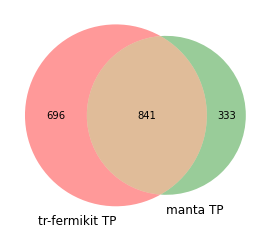

In [5]:
def list_to_value(list_): 
    value, = list_
    return int(value)

overlap_fraction = 0.9

def tr_fermikit_TP_intersect_manta(manta_callset): 
    list_ = ! bedtools intersect -u -wb -f $overlap_fraction -r \
      -a $directory/$job/truvari-pacbio-manta-regions.slopped.coverage-filtered.length-filtered/$manta_callset".vcf" \
      -b $directory/$job/truvari-pacbio-fermi.raw-regions.slopped.coverage-filtered.length-filtered.unitigSupport.thinned/tp-base.vcf \
      | wc -l 
    return list_to_value(list_)

def tr_fermikit_TP_less_manta(manta_callset):
    list_ = ! bedtools subtract -A -f $overlap_fraction -r \
      -a $directory/$job/truvari-pacbio-fermi.raw-regions.slopped.coverage-filtered.length-filtered.unitigSupport.thinned/tp-base.vcf \
      -b $directory/$job/truvari-pacbio-manta-regions.slopped.coverage-filtered.length-filtered/$manta_callset".vcf" \
      | wc -l
    return list_to_value(list_)

def manta_less_tr_fermikit_TP(manta_callset):
    list_ = ! bedtools subtract -A -f $overlap_fraction -r \
      -a $directory/$job/truvari-pacbio-manta-regions.slopped.coverage-filtered.length-filtered/$manta_callset".vcf" \
      -b $directory/$job/truvari-pacbio-fermi.raw-regions.slopped.coverage-filtered.length-filtered.unitigSupport.thinned/tp-base.vcf \
    | wc -l 
    return list_to_value(list_)

def check(manta_callset): 
    if manta_callset != 'fn' and manta_callset != 'tp-base': 
        raise Exception
    else: 
        pass
        
# https://towardsdatascience.com/how-to-create-and-beautify-venn-diagrams-in-python-331129bd4ed3
from matplotlib_venn import venn2

def tr_fermikit_manta_venn2(manta_callset, manta_label):
    check(manta_callset)
    vd = venn2(
        subsets = {
            '10': tr_fermikit_TP_less_manta(manta_callset),
            '11': tr_fermikit_TP_intersect_manta(manta_callset),
            '01': manta_less_tr_fermikit_TP(manta_callset)
        }, 
        set_labels = ('tr-fermikit TP', manta_label))
    return vd

_ = tr_fermikit_manta_venn2(manta_callset='tp-base', manta_label='manta TP')

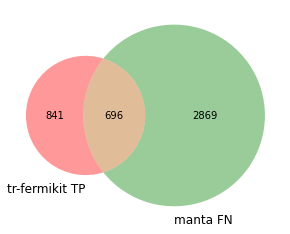

In [6]:
_ = tr_fermikit_manta_venn2(manta_callset='fn', manta_label='manta FN')